In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json
from tool import *

data_root = '../../MyData/'

## Load data

In [2]:
item1_embedding = pd.read_csv(data_root+'merged_1197.csv')
item1_embedding = item1_embedding[['cik', 'tic', 'Year', 'item1_embeddings']]
print(len(item1_embedding))
print(item1_embedding.head())

other_embedding = pd.read_csv(data_root+'output_embeddings_2.csv')
other_embedding = other_embedding[['cik', 'SP_SHORT_DESC_embeddings', 'SP_LONG_DESC_embeddings', 'ORBIS_PROD_SERV_embeddings', 'ORBIS_OVERVIEW_embeddings']]
print(len(other_embedding))
print(other_embedding.head())

total_embedding = pd.merge(item1_embedding, other_embedding, on=['cik'])

# To reduce mem consumption
item1_embedding = ''
other_embedding = ''

print(len(total_embedding))
total_embedding.head()

1197
       cik   tic  Year                                   item1_embeddings
0   850460  WIRE  2021  [0.03955410048365593, -0.04159577935934067, -0...
1   352541   LNT  2021  [-0.0231856107711792, 0.001279839314520359, 0....
2  1704715   AMR  2021  [0.014074714854359627, 0.006938479840755463, 0...
3  1575515   SFM  2021  [-0.023708730936050415, 0.01762891560792923, 0...
4  1125376  ENSG  2021  [0.04463111609220505, 0.0018805989529937506, 0...
1197
       cik                           SP_SHORT_DESC_embeddings  \
0   850460  [0.01568225771188736, -0.07636360824108124, -0...   
1   352541  [-0.013836896046996117, -0.028995024040341377,...   
2  1704715  [0.0030535957776010036, 0.0008783274097368121,...   
3  1575515  [-0.025762900710105896, 0.0034106436651200056,...   
4  1125376  [0.04616139456629753, -0.0021259395871311426, ...   

                             SP_LONG_DESC_embeddings  \
0  [0.06089901179075241, -0.07059630751609802, -0...   
1  [-0.021961161866784096, 0.02030270546674

,cik,tic,Year,item1_embeddings,SP_SHORT_DESC_embeddings,SP_LONG_DESC_embeddings,ORBIS_PROD_SERV_embeddings,ORBIS_OVERVIEW_embeddings
0,850460,WIRE,2021,"[0.03955410048365593, -0.04159577935934067, -0...","[0.01568225771188736, -0.07636360824108124, -0...","[0.06089901179075241, -0.07059630751609802, -0...",NaN,NaN
1,352541,LNT,2021,"[-0.0231856107711792, 0.001279839314520359, 0....","[-0.013836896046996117, -0.028995024040341377,...","[-0.021961161866784096, 0.020302705466747284, ...","[-0.015400929376482964, 0.03232719004154205, -...","[-0.041709959506988525, -0.011898815631866455,..."
2,1704715,AMR,2021,"[0.014074714854359627, 0.006938479840755463, 0...","[0.0030535957776010036, 0.0008783274097368121,...","[-0.0017570963827893138, 0.006557094398885965,...","[-0.02030838653445244, -0.009386725723743439, ...","[-0.012340557761490345, -0.01428779773414135, ..."
3,1575515,SFM,2021,"[-0.023708730936050415, 0.01762891560792923, 0...","[-0.025762900710105896, 0.0034106436651200056,...","[-0.015190708450973034, 0.011541897431015968, ...","[-0.013177500106394291, 0.036401789635419846, ...","[-0.01883152313530445, 0.021741388365626335, 0..."
4,1125376,ENSG,2021,"[0.04463111609220505, 0.0018805989529937506, 0...","[0.04616139456629753, -0.0021259395871311426, ...","[0.05935207009315491, 0.0013673527864739299, 0...","[0.029405493289232254, 0.014010551385581493, 0...","[-0.006068837363272905, 0.010537531226873398, ..."


### Check dataset

In [3]:
nan_proportion = total_embedding.isna().mean()
print(f"The nan value proportion in each column:\n{nan_proportion}\n\n")

The nan value proportion in each column:
cik                           0.000000
tic                           0.000000
Year                          0.000000
item1_embeddings              0.000000
SP_SHORT_DESC_embeddings      0.041771
SP_LONG_DESC_embeddings       0.095238
ORBIS_PROD_SERV_embeddings    0.208020
ORBIS_OVERVIEW_embeddings     0.168755
dtype: float64




## Define fusion function

In [15]:
# def concatenate_fusion(data_df, target_list):
#     modality_content_list = []
#     for target in target_list:
#         temp_list = list(data_df[target].apply(json.loads))
#         modality_content_list.append(temp_list)

#     modality_content_array = np.array(modality_content_list)  # Shape: (3, 1197, 1536)

#     arr_transposed = np.transpose(modality_content_array, (1, 0, 2))  # Shape: (1197, 3, 1536)
#     arr_shape = arr_transposed.shape

#     # Reshape the last two dimensions into a single dimension
#     result = arr_transposed.reshape(arr_shape[0], arr_shape[1]*arr_shape[2])
    
#     return result

## Experiment 1:

Concatenate item1, sp_long, orbis_overview

### concatenate

In [10]:
target_list = ['item1_embeddings', 'SP_LONG_DESC_embeddings', 'ORBIS_OVERVIEW_embeddings']
info_list = ['cik', 'tic', 'Year']
exp1_df = convert_to_array(total_embedding, info_list, target_list, 1536, True)
print(exp1_df.shape)
exp1_df


item1 = np.vstack(exp1_df['item1_embeddings'].values)
sp_long = np.vstack(exp1_df['SP_LONG_DESC_embeddings'].values)
orbis = np.vstack(exp1_df['ORBIS_OVERVIEW_embeddings'].values)
concatenated_np = np.concatenate([item1, sp_long, orbis], axis=1)

print(type(concatenated_np))
print(concatenated_np.shape)
concatenated_np

(926, 6)
<class 'numpy.ndarray'>
(926, 4608)


array([[-0.02318561,  0.00127984,  0.03837442, ..., -0.01639827,
        -0.00884627,  0.01504294],
       [ 0.01407471,  0.00693848,  0.05793545, ..., -0.01053198,
        -0.01884542,  0.01698861],
       [-0.02370873,  0.01762892,  0.03881923, ...,  0.00984779,
         0.01709069, -0.00222528],
       ...,
       [-0.02168068,  0.02275101,  0.01675978, ...,  0.00697548,
         0.00930723, -0.00699524],
       [ 0.02060029,  0.01415954,  0.02986284, ...,  0.00881959,
        -0.01525622, -0.00635244],
       [-0.06847923, -0.00438687,  0.04645469, ..., -0.0006741 ,
        -0.00551236,  0.0016899 ]])

In [7]:
exp1_df = exp1_df[['cik', 'tic', 'Year']]

exp1_df['cluster_10'] = cluster(concatenated_np, 10)
exp1_df['cluster_100'] = cluster(concatenated_np, 100)
exp1_df

Normalized Within-Cluster Sum of Squares (WCSS): 0.000301903706202179
Normalized Within-Cluster Sum of Squares (WCSS): 0.000231705621510157


,cik,tic,Year,cluster_10,cluster_100
1,352541,LNT,2021,5,5
2,1704715,AMR,2021,5,72
3,1575515,SFM,2021,0,53
4,1125376,ENSG,2021,4,55
5,1674335,JELD,2021,7,88
...,...,...,...,...,...
1190,1653653,RRR,2021,2,52
1191,1627223,CC,2021,7,45
1192,1021860,NOV,2021,1,8
1193,1744489,DIS,2021,2,60


In [8]:
# exp1_df.to_csv('1_concatenate_clusters.csv', index=False)

### Evaluate

In [8]:
year = 2021
mode = 'forward'  # Can be 'in-sample', 'forward', or 'backtest'
# returns_long = fetch_stock_data(exp1_df, year, mode)
returns_long = pd.read_csv(data_root+"returns_long.csv")

exp1_returns = pd.merge(exp1_df, returns_long, on='tic', how='inner')

exp1_intra_corrs_10 = intra_industry_correlations(exp1_returns, "cluster_10")
exp1_avg_intra_corr_10 = np.nanmean(list(exp1_intra_corrs_10.values()))
print(exp1_avg_intra_corr_10)

exp1_intra_corrs_100 = intra_industry_correlations(exp1_returns, "cluster_100")
exp1_avg_intra_corr_100 = np.nanmean(list(exp1_intra_corrs_100.values()))
print(exp1_avg_intra_corr_100)

print(len(exp1_returns['cik'].unique()))

0.36940339079749923
0.430472927797262
924


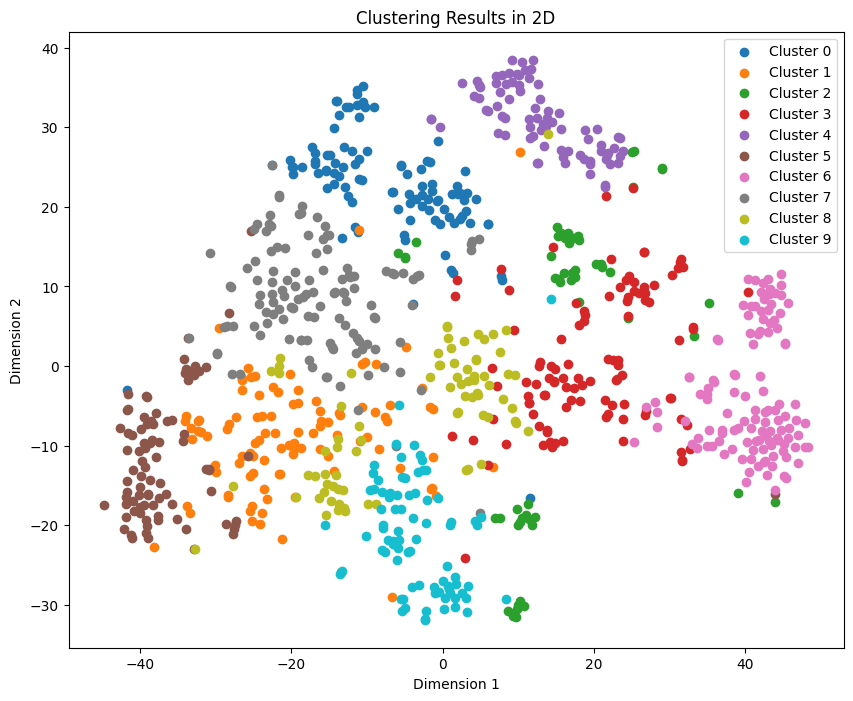

In [9]:
show_cluster_graph(concatenated_np, exp1_df['cluster_10'])

## Experient 2:

Concatenate item1, sp_long, sp_short

### concatenate

In [17]:
target_list = ['item1_embeddings', 'SP_LONG_DESC_embeddings', 'SP_SHORT_DESC_embeddings']
info_list = ['cik', 'tic', 'Year']
exp2_df = convert_to_array(total_embedding, info_list, target_list, 1536, True)
print(exp2_df.shape)
exp2_df


item1 = np.vstack(exp2_df['item1_embeddings'].values)
sp_long = np.vstack(exp2_df['SP_LONG_DESC_embeddings'].values)
sp_short = np.vstack(exp2_df['SP_SHORT_DESC_embeddings'].values)
concatenated_np = np.concatenate([item1, sp_long, sp_short], axis=1)

print(type(concatenated_np))
print(concatenated_np.shape)
concatenated_np

(1083, 6)
<class 'numpy.ndarray'>
(1083, 4608)


array([[ 0.0395541 , -0.04159578, -0.01619731, ..., -0.04097864,
        -0.00316205,  0.04387536],
       [-0.02318561,  0.00127984,  0.03837442, ...,  0.00101044,
        -0.00172511,  0.01498997],
       [ 0.01407471,  0.00693848,  0.05793545, ...,  0.00833574,
        -0.03363522,  0.01407759],
       ...,
       [-0.02168068,  0.02275101,  0.01675978, ...,  0.00643672,
         0.01606878,  0.00074254],
       [ 0.02060029,  0.01415954,  0.02986284, ...,  0.0233734 ,
         0.01609699,  0.01128678],
       [-0.06847923, -0.00438687,  0.04645469, ...,  0.00550124,
        -0.00698685, -0.01824066]])

In [18]:
exp2_df = exp2_df[['cik', 'tic', 'Year']]

exp2_df['cluster_10'] = cluster(concatenated_np, 10)
exp2_df['cluster_100'] = cluster(concatenated_np, 100)
exp2_df

Normalized Within-Cluster Sum of Squares (WCSS): 0.0003173942703166314
Normalized Within-Cluster Sum of Squares (WCSS): 0.00025121207076494567


,cik,tic,Year,cluster_10,cluster_100
0,850460,WIRE,2021,7,66
1,352541,LNT,2021,4,11
2,1704715,AMR,2021,4,48
3,1575515,SFM,2021,6,8
4,1125376,ENSG,2021,5,57
...,...,...,...,...,...
1190,1653653,RRR,2021,9,49
1191,1627223,CC,2021,2,89
1192,1021860,NOV,2021,7,70
1193,1744489,DIS,2021,9,23


### Evaluate

In [19]:
year = 2021
mode = 'forward'  # Can be 'in-sample', 'forward', or 'backtest'
# returns_long = fetch_stock_data(exp2_df, year, mode)
returns_long = pd.read_csv(data_root+"returns_long.csv")

exp2_returns = pd.merge(exp2_df, returns_long, on='tic', how='inner')

exp2_intra_corrs_10 = intra_industry_correlations(exp2_returns, "cluster_10")
exp2_avg_intra_corr_10 = np.nanmean(list(exp2_intra_corrs_10.values()))
print(exp2_avg_intra_corr_10)

exp2_intra_corrs_100 = intra_industry_correlations(exp2_returns, "cluster_100")
exp2_avg_intra_corr_100 = np.nanmean(list(exp2_intra_corrs_100.values()))
print(exp2_avg_intra_corr_100)

print(len(exp2_returns['cik'].unique()))

0.3802146200376737
0.43152164040312174
973
